In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

One year ago from the last data point is 2016-08-23.


<AxesSubplot:title={'center':'Precipitation over Time'}, xlabel='Date', ylabel='Precipitation (inches)'>

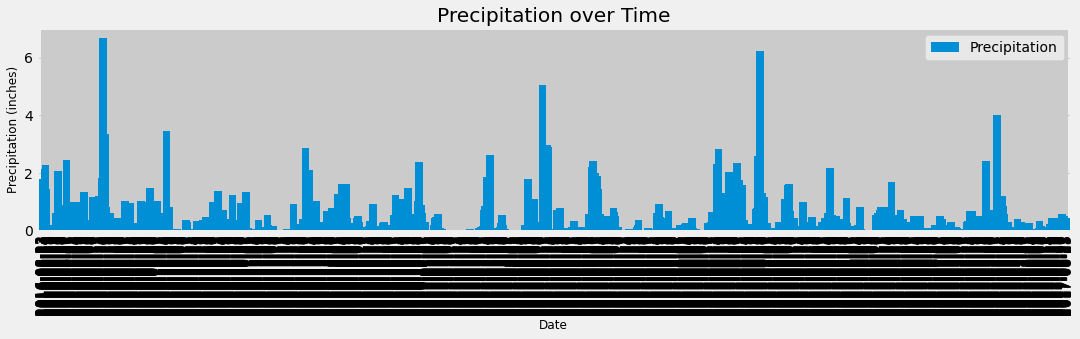

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
recent_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
(last_point,) = recent_date
last_point = dt.datetime.strptime(last_point, '%Y-%m-%d')
last_point = last_point.date()
one_year = last_point-dt.timedelta(days=365)
print(f"One year ago from the last data point is {one_year}.")

# Perform a query to retrieve the data and precipitation scores
Data = session.query(Measurements.date,Measurements.prcp).\
    filter(Measurements.date>=one_year).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
Data_df = pd.DataFrame(Data, columns = ['Date', 'Precipitation']).set_index('Date')
# Drop null values (if any).
Data_df = Data_df.dropna(how="any")
# Sort the dataframe by date
Data_df = Data_df.sort_values(by=['Date'])
Data_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
Rain_plot = Data_df.plot(kind='bar', title="Precipitation over Time", figsize=(15,5), width=15, legend=True)
plt.tight_layout()
Rain_plot.grid(zorder=1)
Rain_plot.set_xlabel("Date", fontsize=12)
Rain_plot.set_ylabel("Precipitation (inches)", fontsize=12)
plt.savefig("Plots/Precipitation_over_Time")
Rain_plot

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Data_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Stations.station).count()
print(f"This data set contains {num_stations} stations.")

This data set contains 9 stations.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
counts = session.query(Measurements.station, func.count()).\
    group_by(Measurements.station).\
    order_by(func.count().desc()).all()
for station, count in counts:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
Active_station = session.query(Measurements.station).\
    group_by(Measurements.station).\
    order_by(func.count().desc()).first()
(station_ID,)=Active_station
print(f"The most active station is {station_ID}.")
temps = session.query(func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)).\
                      filter(Measurements.station == station_ID).all()
                      
for min_temp, max_temp, avg_temp in temps:
    print(f"The lowest temperature recorderd at {station_ID} was {min_temp}.")
    print(f"The highest temperature recorderd at {station_ID} was {max_temp}.")
    print(f"The average temperature recorderd at {station_ID} was {avg_temp}.")

The most active station is USC00519281.
The lowest temperature recorderd at USC00519281 was 54.0.
The highest temperature recorderd at USC00519281 was 85.0.
The average temperature recorderd at USC00519281 was 71.66378066378067.


<AxesSubplot:title={'center':'Temperature Distribution at station USC00519281'}, xlabel='Temperature (F)', ylabel='Frequency'>

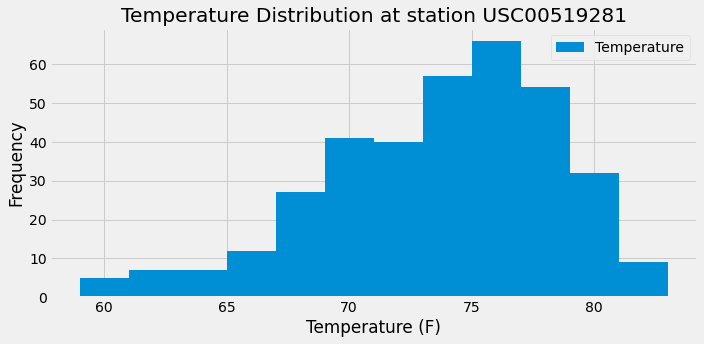

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Calculate 12 months before recent point 
Active_Station_Date = session.query(Measurements.date).\
    order_by(Measurements.date.desc()).\
    filter(Measurements.station == station_ID).\
    first()

(last_point,) = Active_Station_Date
last_point = dt.datetime.strptime(last_point, '%Y-%m-%d')
last_point = last_point.date()
one_year = last_point-dt.timedelta(days=365)

#Filter to grab a years worth of data
Year_Station_Data = session.query(Measurements.date,Measurements.tobs).\
    filter(Measurements.date>=one_year).\
    filter(Measurements.station == station_ID).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
Temp_df = pd.DataFrame(Year_Station_Data, columns = ['Date', 'Temperature']).set_index('Date')

# Drop null values (if any).
Temp_df = Temp_df.dropna(how="any")

# Sort the dataframe by date
Temp_df = Temp_df.sort_values(by=['Date'])

Temp_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
Temp_hist = Temp_df.plot(kind='hist', title=f"Temperature Distribution at station {station_ID}", figsize=(10,5), legend=True, bins=12)
Temp_hist.set_xlabel('Temperature (F)')
plt.tight_layout()
plt.savefig("Plots/Temp_at_Station")
Temp_hist

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.date(2017, 6, 12)
end_date = dt.date(2017, 6, 20)
print(calc_temps(start_date, end_date))
vaca_temps = calc_temps('2017-06-12', '2017-06-20')

[(72.0, 76.91525423728814, 83.0)]


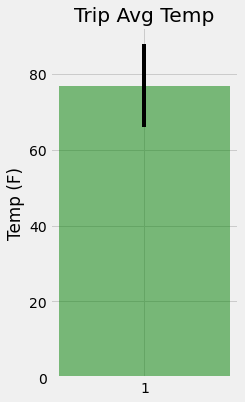

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(3,6))
x_pos=[1]
min_temp = [x[0] for x in vaca_temps]
avg_temp = [x[1] for x in vaca_temps]
max_temp = [x[2] for x in vaca_temps]

error = max_temp[0] - min_temp[0]

ax.bar(x_pos, avg_temp, yerr=[error], color = 'g' ,align='center', alpha=0.5, ecolor='k')
ax.set_ylabel('Temp (F)')
ax.set_xticks(x_pos)
ax.set_title("Trip Avg Temp")
plt.savefig("Plots/AvgTemp")
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(Measurements.station, Stations.name, Stations.latitude, Stations.longitude, Stations.elevation, func.sum(Measurements.prcp)).\
filter(Measurements.station == Stations.station).\
filter(Measurements.date >= start_date).\
filter(Measurements.date <= end_date).\
group_by(Measurements.station).\
order_by(func.sum(Measurements.prcp).desc()).all()

# Make into DataFrame
rainfall_DF = pd.DataFrame(rainfall, columns=["Station", "Name", "Latitude", "Longitude", "Elevation", "Total Rainfall"])
rainfall_DF

,Station,Name,Latitude,Longitude,Elevation,Total Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,5.57
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.71
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.70
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.54
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.24
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.09
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurements.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_day = dt.datetime.strftime(start_date, "%m-%d")
end_day = dt.datetime.strftime(end_date, "%m-%d")

start_day = dt.datetime.strptime(start_day, "%m-%d")
end_day = dt.datetime.strptime(end_day, "%m-%d")

# Use the start and end date to create a range of dates
date_range = (start_day + dt.timedelta(days = x) for x in range (0, ((end_day-start_day).days)+1))
# Stip off the year and save a list of %m-%d strings
dates_list = []
for day in date_range:
    date = day.strftime("%m-%d")
    dates_list.append(date)

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals_list = []
for date in dates_list:
    daily_normals_list.append(daily_normals(date))

print(daily_normals_list)

min_temps = []
avg_temps = []
max_temps = []
for Daily_Normals in daily_normals_list:
    for min_temp, avg_temp, max_temp in Daily_Normals:
        min_temps.append(min_temp)
        avg_temps.append(avg_temp)
        max_temps.append(max_temp)

[[(66.0, 75.66666666666667, 83.0)], [(68.0, 75.66666666666667, 81.0)], [(69.0, 75.62711864406779, 81.0)], [(67.0, 75.40350877192982, 81.0)], [(69.0, 75.41379310344827, 81.0)], [(68.0, 74.59322033898304, 81.0)], [(69.0, 74.60344827586206, 80.0)], [(70.0, 75.44067796610169, 82.0)], [(68.0, 73.96491228070175, 85.0)]]


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

DailyNormals = pd.DataFrame({
    "Trip Dates": dates_list,
    "Min Temp":min_temps,
    "Avg Temp": avg_temps,
    "Max Temp": max_temps
}).set_index("Trip Dates")

DailyNormals

,Min Temp,Avg Temp,Max Temp
Trip Dates,,,
06-12,66.0,75.666667,83.0
06-13,68.0,75.666667,81.0
06-14,69.0,75.627119,81.0
06-15,67.0,75.403509,81.0
06-16,69.0,75.413793,81.0
06-17,68.0,74.593220,81.0
06-18,69.0,74.603448,80.0
06-19,70.0,75.440678,82.0
06-20,68.0,73.964912,85.0


<AxesSubplot:title={'center':'Daily Normals from June 12 to June 20'}, xlabel='Date', ylabel='Temperature (F)'>

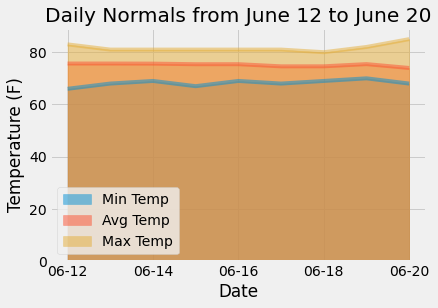

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
Trip_Plan = DailyNormals.plot.area(stacked=False)
Trip_Plan.set_title(f"Daily Normals from June 12 to June 20")
Trip_Plan.set_xlabel("Date")
Trip_Plan.set_ylabel("Temperature (F)")
plt.savefig("Plots/DailyNormals")
Trip_Plan
                    